In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import scipy.signal
import hdf5storage
import librosa

from model import *
from tb_utils import *
from preprocessing import *

from scipy import io

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay

In [50]:
default_envelope_config = {
    'homomorphic_envelogram_with_hilbert': {'lpf_frequency': 8},
    'psd': {'fl_low': 40, 'fl_high': 60, 'resample': True},
    'wavelet': {'wavelet': 'db1',
                'levels': [4],
                'start_level': 1,
                'end_level': 5,
                'erase_pad': True}
}

In [68]:
recording_40840, frequency = librosa.load('./40840_TV.wav', sr=None)
pre_proc_data_40840_orig=renna_preprocess_wave(input_signal=recording_40840, fs=4000, config_dict=default_envelope_config)

"""
N=64
x_in = recording_40840
x_out = pre_proc_data_40840_orig[:,236:1004]

X_in = np.zeros((N*80))
X_out = np.zeros((4, N))

for k in range(0, len(x_in), N*80):
    if k + N*80 > len(x_in):
        # If the window is smaller than N, discard it
        continue
    
    else: 
        input = x_in[k:k+(N*80)]
        output = x_out[:, round(k/80):round(k/80)+N]
        print(output.shape)

        X_in = np.vstack((X_in, input))
        X_out = np.dstack((X_out, output))  

X_in = X_in[1:,:]
X_out = X_out[:,:,1:]
"""

'\nN=64\nx_in = recording_40840\nx_out = pre_proc_data_40840_orig[:,236:1004]\n\nX_in = np.zeros((N*80))\nX_out = np.zeros((4, N))\n\nfor k in range(0, len(x_in), N*80):\n    if k + N*80 > len(x_in):\n        # If the window is smaller than N, discard it\n        continue\n    \n    else: \n        input = x_in[k:k+(N*80)]\n        output = x_out[:, round(k/80):round(k/80)+N]\n        print(output.shape)\n\n        X_in = np.vstack((X_in, input))\n        X_out = np.dstack((X_out, output))  \n\nX_in = X_in[1:,:]\nX_out = X_out[:,:,1:]\n'

In [244]:
def create_patches(input, patch_size = 64, stride = 64):
    patches = []
    for i in range(0, input.shape[1], stride):
        if i + patch_size < input.shape[1]:
            patches.append(input[:,i:i+patch_size])
    return np.array(patches)

In [245]:
cnn_in_origi = create_patches(pre_proc_data_40840_orig)
cnn_in_origi = np.reshape(cnn_in_origi, (cnn_in_origi.shape[0], cnn_in_origi.shape[2], cnn_in_origi.shape[1]))


In [51]:
model = get_model()
model.load_weights('parameters.h5')

In [246]:
#tmp = np.reshape(X_out[:,:,:], (-1, 64, 4))
#tmp= tf.convert_to_tensor(tmp, dtype=tf.float32)
output_orig = model.predict(cnn_in_origi)
#output = output.numpy()

output_argm = np.argmax(output_orig, axis=-1) #should be +1
output_argm = output_argm.reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


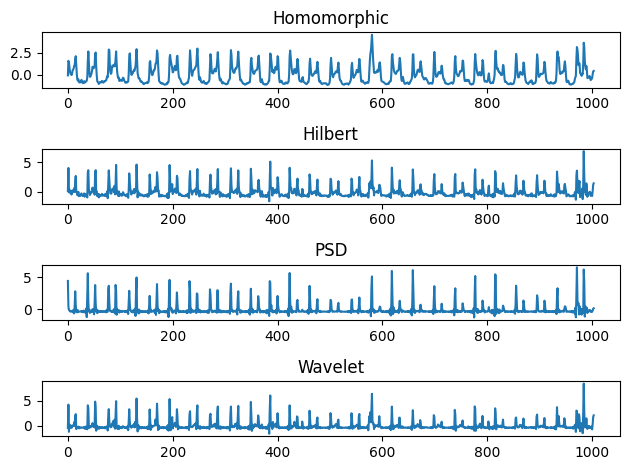

In [247]:
#recording_2530, frequency = librosa.load(r'C:\Users\domen\Desktop\eneriz_tb_gen\14241_PV.wav', sr=None)
#pre_proc_data_2530_orig=renna_preprocess_wave(input_signal=recording_2530, fs=4000, config_dict=default_envelope_config)
#X_out_2530_orig = patch_fun(recording_2530[1040:], pre_proc_data_2530_orig[:,13:])

plt.subplot(4,1,1)
plt.plot(pre_proc_data_40840_orig[0], label='Homomorphic')
plt.title('Homomorphic')
plt.subplot(4,1,2)
plt.plot(pre_proc_data_40840_orig[1], label='Hilbert')
plt.title('Hilbert')
plt.subplot(4,1,3)
plt.plot(pre_proc_data_40840_orig[2], label='PSD')
plt.title('PSD')
plt.subplot(4,1,4)
plt.plot(pre_proc_data_40840_orig[3], label='Wavelet')
plt.title('Wavelet')

plt.tight_layout()


In [52]:
swt_envelope_logic = hdf5storage.loadmat('./40840_data/swt_env_40840.mat')
swt_envelope_logic = swt_envelope_logic['swt_env']
swt_envelope_logic = np.squeeze(swt_envelope_logic)

psd_envelope_logic = hdf5storage.loadmat('./40840_data/psd_env_40840.mat')
psd_envelope_logic = psd_envelope_logic['psd_env']
psd_envelope_logic = np.squeeze(psd_envelope_logic)

homo_envelope_logic = hdf5storage.loadmat('./40840_data/homo_env_40840.mat')
homo_envelope_logic = homo_envelope_logic['homo_env']
homo_envelope_logic = np.squeeze(homo_envelope_logic)

hilb_envelope_logic = hdf5storage.loadmat('./40840_data/hilb_env_40840.mat')
hilb_envelope_logic = hilb_envelope_logic['hilb_env']
hilb_envelope_logic = np.squeeze(hilb_envelope_logic)

In [99]:
"""
import scienceplots

plt.style.use(['science','ieee'])

fig, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(pre_proc_data_40840_orig[0][0:192], label='Homomorphic original')
axs[0].plot(homo_envelope_logic[0:192], label='Homomorphic circuit')
axs[0].axvline(x=64, linestyle='--')
axs[0].axvline(x=128, linestyle='--')
axs[0].axvline(x=192, linestyle='--')
axs[0].text(155, 0.4, f'Homomorphic', horizontalalignment='center', verticalalignment='center')

axs[1].plot(pre_proc_data_40840_orig[1][0:192], label='Hilbert original')
axs[1].plot(hilb_envelope_logic[1:193], label='Hilbert circuit')
axs[1].axvline(x=64, linestyle='--')
axs[1].axvline(x=128, linestyle='--')
axs[1].axvline(x=192, linestyle='--')
axs[1].text(155, 0.17, f'Hilbert', horizontalalignment='center', verticalalignment='center')

axs[2].plot(pre_proc_data_40840_orig[2][0:192], label='PSD original')
axs[2].plot(psd_envelope_logic[1:193], label='PSD circuit')
axs[2].axvline(x=64, linestyle='--')
axs[2].axvline(x=128, linestyle='--')
axs[2].axvline(x=192, linestyle='--')
axs[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axs[2].text(155, 0.00028, f'PSD', horizontalalignment='center', verticalalignment='center')

axs[3].plot(pre_proc_data_40840_orig[3][0:192], label='Original envelogram')
axs[3].plot(swt_envelope_logic[0:192], label='IP envelogram')
axs[3].axvline(x=64, linestyle='--')
axs[3].axvline(x=128, linestyle='--')
axs[3].axvline(x=192, linestyle='--')
axs[3].text(155, 0.1, f'SWT', horizontalalignment='center', verticalalignment='center')

#axs[0].legend(loc='lower center', ncol=2)

axs[3].set_xlabel('Samples')

for ax in axs:
    ax.set_xlim(0, 192)
    ax.set_xticks([0, 64, 128, 192])

fig.tight_layout()

plt.savefig('envelopes_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
"""


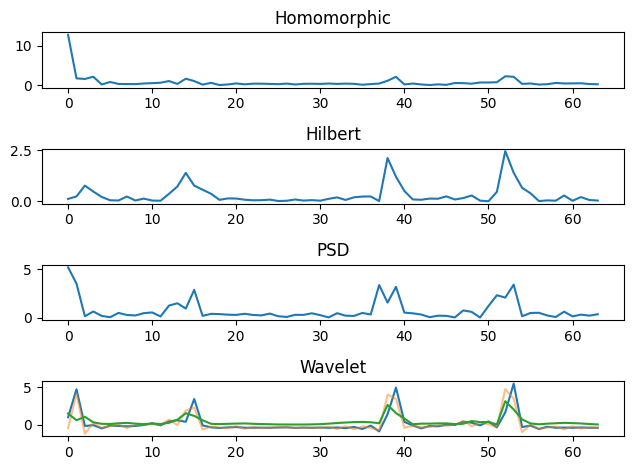

'\n#patching\nN=64\nx_in = recording_40840\nx_out = x\n\nX_in = np.zeros((N*80))\nX_out = np.zeros((4, N))\n\nfor k in range(0, len(x_in), N*80):\n    if k + N*80 > len(x_in):\n        # If the window is smaller than N, discard it\n        continue\n    \n    else: \n        input = x_in[k:k+(N*80)]\n        output = x_out[:, round(k/80):round(k/80)+N]\n\n        X_in = np.vstack((X_in, input))\n        X_out = np.dstack((X_out, output))  \n\nX_in = X_in[1:,:]\nX_out = X_out[:,:,1:]\n'

In [53]:
#standardization
swt = swt_envelope_logic[0:1004]
homo = homo_envelope_logic[0:1004]
hilb = hilb_envelope_logic[1:1005]
psd = psd_envelope_logic[1:1005]

#swt = pre_proc_data_40840_orig[3] + np.random.normal(0,0.3, len(pre_proc_data_40840_orig[3]))
#homo = pre_proc_data_40840_orig[0] + np.random.normal(0,0.3, len(pre_proc_data_40840_orig[0]))
#hilb = pre_proc_data_40840_orig[1] + np.random.normal(0,0.3, len(pre_proc_data_40840_orig[1]))
#psd = pre_proc_data_40840_orig[2] + np.random.normal(0,0.3, len(pre_proc_data_40840_orig[2]))

#swt = (swt - swt.mean()) / swt.std()
#homo = (homo - swt.mean()) / homo.std()
#hilb = (hilb - swt.mean()) / hilb.std()
#psd = (psd - psd.mean()) / psd.std()

#collection
envelopes = []
envelopes.append(homo)
envelopes.append(hilb)
envelopes.append(psd)
envelopes.append(swt)

x = np.stack(envelopes, axis=0)

x = (x - x.mean(axis=1, keepdims=True)) / x.std(axis=1, keepdims=True)


plt.subplot(4,1,1)
plt.plot(x[0][0:64], label='Homomorphic')
plt.plot(pre_proc_data_40840_orig[0][0:64], label='Homomorphic')

plt.title('Homomorphic')
plt.subplot(4,1,2)
plt.plot(x[1][0:64], label='Hilbert')
plt.plot(pre_proc_data_40840_orig[1][0:64], label='Hilbert')

plt.title('Hilbert')
plt.subplot(4,1,3)
plt.plot(x[2][0:64], label='PSD')
plt.plot(pre_proc_data_40840_orig[2][0:64], label='PSD')

plt.title('PSD')
plt.subplot(4,1,4)
plt.plot(x[3][0:64], label='Wavelet')
plt.plot(pre_proc_data_40840_orig[3][0:64], label='Wavelet')

plt.title('Wavelet')

plt.tight_layout()
plt.show()

plt.subplot(4,1,1)
plt.plot(abs(x[0]-pre_proc_data_40840_orig[0])[0:64], label='Homomorphic')

plt.title('Homomorphic')
plt.subplot(4,1,2)
plt.plot(abs(x[1]-pre_proc_data_40840_orig[1])[0:64], label='Hilbert')

plt.title('Hilbert')
plt.subplot(4,1,3)
plt.plot(abs(x[2]-pre_proc_data_40840_orig[1])[0:64], label='PSD')

plt.title('PSD')
plt.subplot(4,1,4)
plt.plot(x[3][0:64], label='Wavelet')
plt.plot(pre_proc_data_40840_orig[3][0:64], label='Wavelet',alpha=0.5)
plt.plot(abs(x[3]-pre_proc_data_40840_orig[3])[0:64], label='Wavelet')

plt.title('Wavelet')

plt.tight_layout()
plt.show()

#np.save('40840_new_envelops',x)
"""
#patching
N=64
x_in = recording_40840
x_out = x

X_in = np.zeros((N*80))
X_out = np.zeros((4, N))

for k in range(0, len(x_in), N*80):
    if k + N*80 > len(x_in):
        # If the window is smaller than N, discard it
        continue
    
    else: 
        input = x_in[k:k+(N*80)]
        output = x_out[:, round(k/80):round(k/80)+N]

        X_in = np.vstack((X_in, input))
        X_out = np.dstack((X_out, output))  

X_in = X_in[1:,:]
X_out = X_out[:,:,1:]
"""

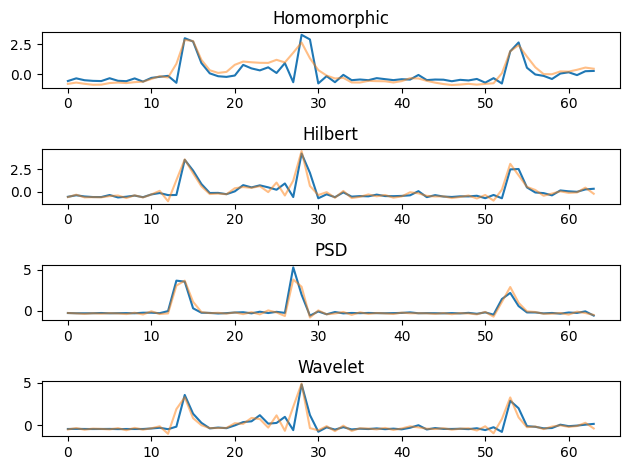

In [278]:
plt.subplot(4,1,1)
plt.plot(x[0][64:128], label='Homomorphic')
plt.plot(pre_proc_data_40840_orig[0][64:128], label='Homomorphic',alpha=0.5)

plt.title('Homomorphic')
plt.subplot(4,1,2)
plt.plot(x[1][64:128], label='Hilbert')
plt.plot(pre_proc_data_40840_orig[1][64:128], label='Hilbert',alpha=0.5)

plt.title('Hilbert')
plt.subplot(4,1,3)
plt.plot(x[2][64:128], label='PSD')
plt.plot(pre_proc_data_40840_orig[2][64:128], label='PSD',alpha=0.5)

plt.title('PSD')
plt.subplot(4,1,4)
plt.plot(x[3][64:128], label='Wavelet')
plt.plot(pre_proc_data_40840_orig[3][64:128], label='Wavelet',alpha=0.5)

plt.title('Wavelet')

plt.tight_layout()
plt.show()

In [317]:
fpga_in = create_patches(x)
fpga_in = np.reshape(fpga_in, (fpga_in.shape[0], fpga_in.shape[2], fpga_in.shape[1]))

In [318]:
#model = get_model()
#model.load_weights('parameters.h5')

#tmp = np.reshape(X_out[:,:,:], (-1, 64, 4))
#tmp= tf.convert_to_tensor(tmp, dtype=tf.float32)
output = model.predict(fpga_in)
#output = output.numpy()

output_argm_new = np.argmax(output, axis=-1) #should be +1
output_argm_new = output_argm_new.reshape(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


0.5
Confusion matrix, without normalization
[[ 41   9  24  35]
 [ 17  61   4  74]
 [ 31  22  43  46]
 [ 37 115  66 335]]
Normalized confusion matrix
[[0.37614679 0.08256881 0.22018349 0.32110092]
 [0.10897436 0.39102564 0.02564103 0.47435897]
 [0.21830986 0.15492958 0.3028169  0.32394366]
 [0.06690778 0.2079566  0.11934901 0.60578662]]


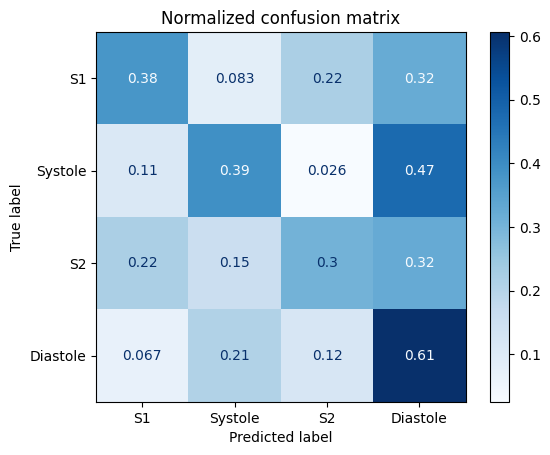

In [319]:
acc_value = accuracy_score(output_argm, output_argm_new, normalize=True)
print(acc_value)

matrix = confusion_matrix(output_argm, output_argm_new)
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        output_argm,
        output_argm_new,
        display_labels=['S1', 'Systole', 'S2', 'Diastole'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[ 41   9  24  35]
 [ 17  61   4  74]
 [ 31  22  43  46]
 [ 37 115  66 335]]
Normalized confusion matrix
[[0.37614679 0.08256881 0.22018349 0.32110092]
 [0.10897436 0.39102564 0.02564103 0.47435897]
 [0.21830986 0.15492958 0.3028169  0.32394366]
 [0.06690778 0.2079566  0.11934901 0.60578662]]


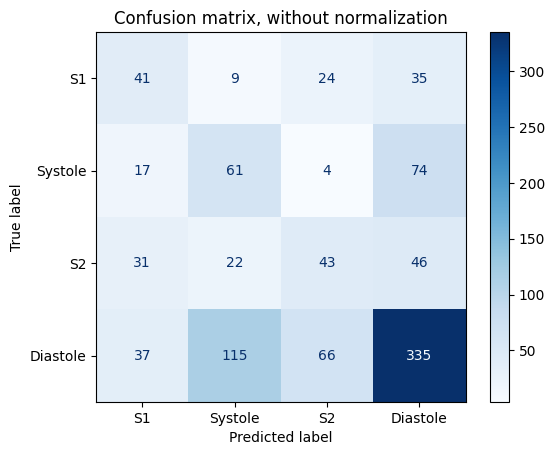

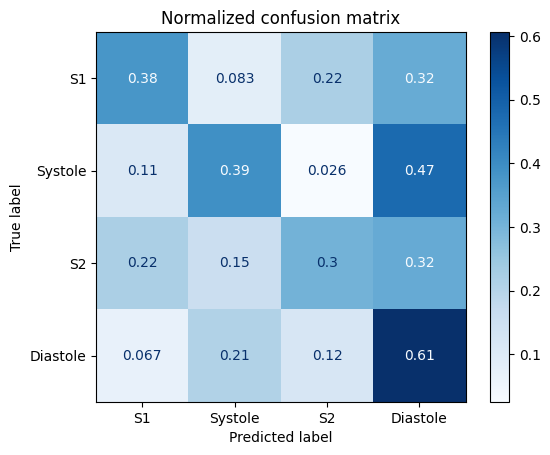

In [321]:
antonio_cnn_out = np.load('40840_AV_cnn_output.npy')
antonio_cnn_out = np.argmax(antonio_cnn_out, axis=-1) #should be +1
antonio_cnn_out = antonio_cnn_out.reshape(-1)

acc_value = accuracy_score(antonio_cnn_out, output_argm_new, normalize=True)

matrix = confusion_matrix(antonio_cnn_out, output_argm_new)
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        output_argm,
        output_argm_new,
        display_labels=['S1', 'Systole', 'S2', 'Diastole'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

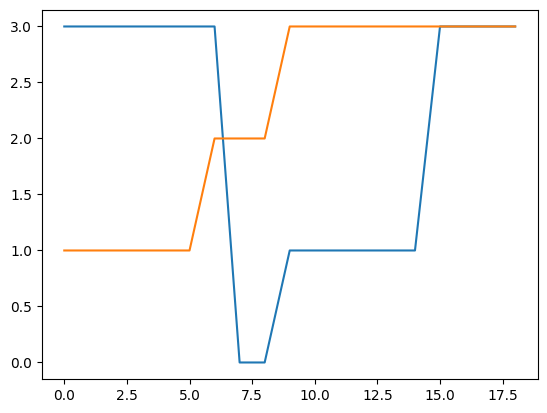

In [342]:
plt.plot(antonio_cnn_out[5:24], label='Antonio')
plt.plot(output_argm_new[5:24])
#plt.xticks([0, 4, 8, 12, 16, 20, 24])
plt.show()

#plt.legend()

In [69]:
with open("40840_TV.tsv", 'r') as f:
    data = f.read()

data = data.split('\n')

input_data = np.empty((len(data)-1, 3), dtype=float)  # Creazione di un array vuoto con le dimensioni corrette

for i in range(len(data)-1):
    row_values = data[i].split('\t')
    for j in range(len(row_values)):
        input_data[i, j] = float(row_values[j])

# Find the duration in seconds of the recording (last value of the second column)
T = input_data[-1,1]

# Generate a time array with 50 Hz sampling rate
t = np.arange(0, T, 1.0/50.0)

# Generate the s array
s = np.zeros_like(t)

# For each time instant, find its heart state and assign it to the s array
for i in range(len(t)):
    # Find the first value greater than t(i)
    j = np.argmax(input_data[:,1] > t[i])
    # Assign the heart state to s(i)
    s[i] = input_data[j,2]

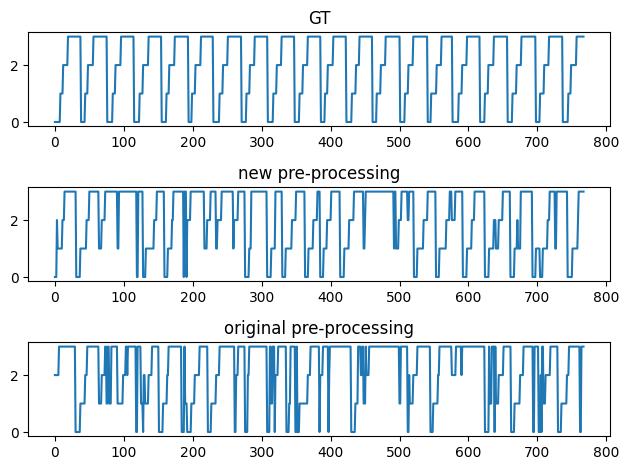

In [398]:
plt.subplot(3,1,1)
plt.plot(s[0:768]-1)
plt.title('GT')
plt.subplot(3,1,2)
plt.plot(output_argm_new[0:768])
plt.title('new pre-processing')
plt.subplot(3,1,3)
plt.plot(output_argm[0:768])
plt.title('original pre-processing')
plt.tight_layout()
plt.show()

In [400]:
x_strided=rolling_strided_window(x,64,8)
x_strided = np.reshape(x_strided, (x_strided.shape[0], x_strided.shape[2], x_strided.shape[1]))
output = model.predict(x_strided)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 


In [389]:
acc_value = accuracy_score(s[0:960]-1, output_argm_new[0:960], normalize=True)

matrix = confusion_matrix(s[0:960]-1, output_argm_new[0:960])
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

print(acc_value)
print(per_class_accuracy)
print(matrix)

0.340625
[0.16022099 0.2109375  0.10344828 0.53039832]
[[ 29  39  26  87]
 [ 24  27  15  62]
 [ 25  43  18  88]
 [ 48  98  78 253]]


In [387]:
acc_value = accuracy_score(s[0:960]-1, output_argm[0:960], normalize=True)

matrix = confusion_matrix(s[0:960]-1, output_argm[0:960])
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

print(acc_value)
print(per_class_accuracy)
print(matrix)

0.4041666666666667
[0.15469613 0.21875    0.14367816 0.64360587]
[[ 28  31  28  94]
 [ 27  28  13  60]
 [  9  48  25  92]
 [ 45  49  76 307]]


In [391]:
acc_value = accuracy_score(s[0:960]-1, antonio_cnn_out[0:960], normalize=True)

matrix = confusion_matrix(s[0:960]-1, antonio_cnn_out[0:960])
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

print(acc_value)
print(per_class_accuracy)
print(matrix)

0.43125
[0.14917127 0.28125    0.15517241 0.67924528]
[[ 27  35  23  96]
 [ 21  36  10  61]
 [  8  53  27  86]
 [ 46  44  63 324]]


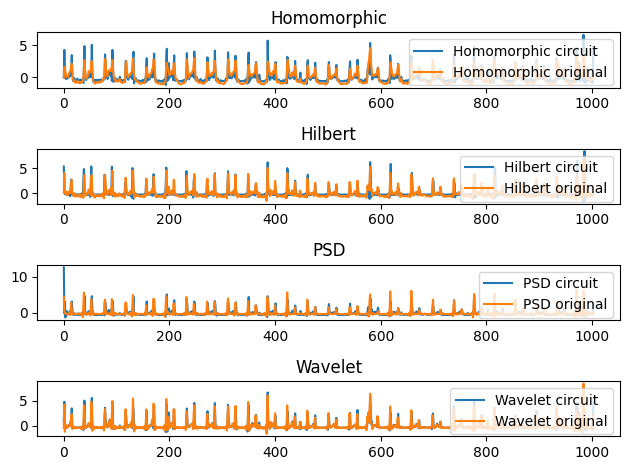

In [12]:
plt.subplot(4,1,1)
plt.plot(homo, label='Homomorphic circuit')
plt.plot(pre_proc_data_40840_orig[0], label='Homomorphic original')
plt.title('Homomorphic')
plt.legend(loc='upper right')
plt.subplot(4,1,2)
plt.plot(hilb, label='Hilbert circuit')
plt.plot(pre_proc_data_40840_orig[1], label='Hilbert original')
plt.title('Hilbert')
plt.legend(loc='upper right')
plt.subplot(4,1,3)
plt.plot(powersd, label='PSD circuit')
plt.plot(pre_proc_data_40840_orig[2], label='PSD original')
plt.title('PSD')
plt.legend(loc='upper right')
plt.subplot(4,1,4)
plt.plot(swt, label='Wavelet circuit')
plt.plot(pre_proc_data_40840_orig[3], label='Wavelet original')
plt.title('Wavelet')
plt.legend(loc='upper right')
plt.tight_layout()

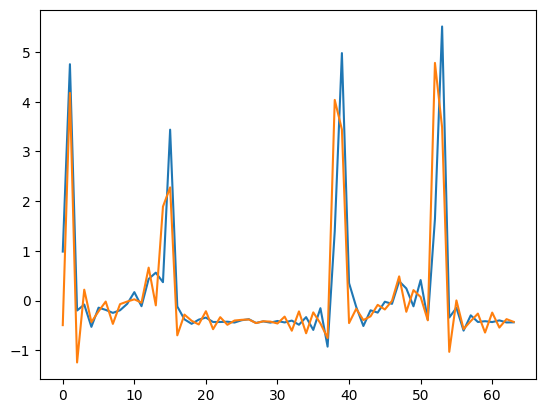

In [14]:
plt.plot(swt[0:64], label='Wavelet circuit')
plt.plot(pre_proc_data_40840_orig[3][0:64], label='Wavelet original')

C:\Users\domen\AppData\Local\Temp\ipykernel_48412\1479728223.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


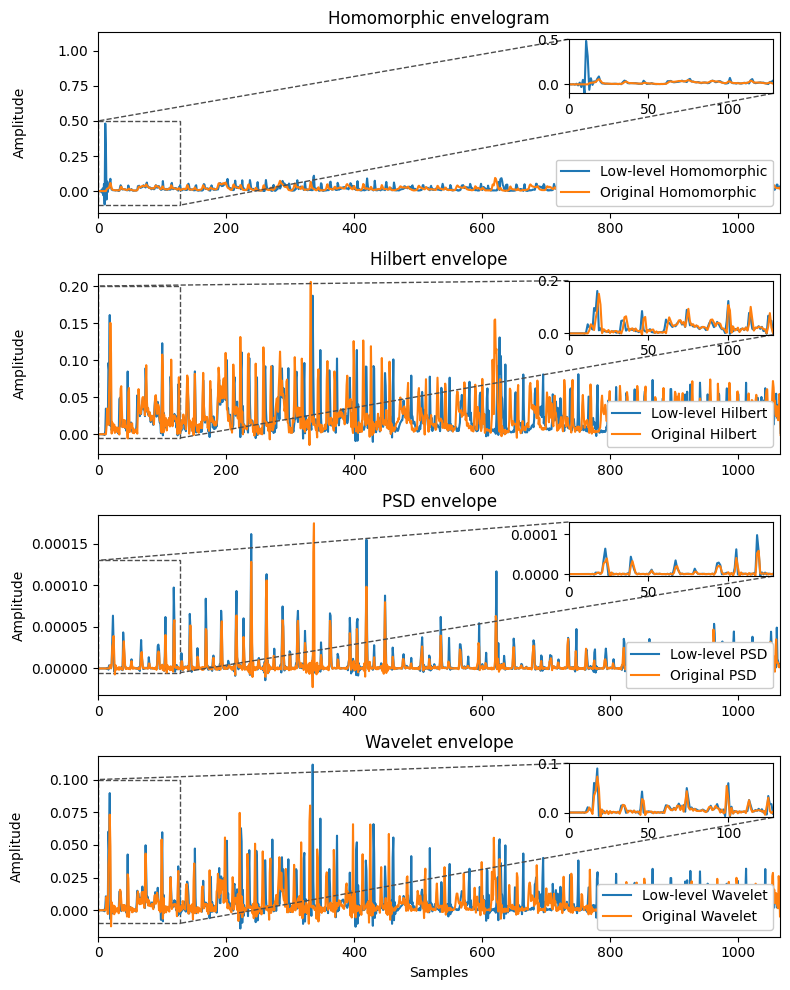

In [113]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 10))
homo_orig = pre_proc_data_40840_orig[0]
hilb_orig = pre_proc_data_40840_orig[1]
psd_orig = pre_proc_data_40840_orig[2]
swt_orig = pre_proc_data_40840_orig[3]

# Plot data in each subplot
axs[0].plot(homo_envelope_logic[:1180], label='Low-level Homomorphic')
axs[0].plot(homo_orig, label='Original Homomorphic')
axs[0].set_title('Homomorphic envelogram')
axs[0].legend(loc='lower right',framealpha=1)
axs[0].set_ylabel('Amplitude', labelpad=22)
axs[0].set_xlim(0, 1065)

ax_indicate_0 = inset_axes(axs[0], width="30%", height="30%", loc='upper right')
ax_indicate_0.plot(axs[0].lines[0].get_xdata(), axs[0].lines[0].get_ydata())
ax_indicate_0.plot(axs[0].lines[1].get_xdata(), axs[0].lines[1].get_ydata())
ax_indicate_0.set_xlim(0, 128)  # Adjust the limits according to your data
ax_indicate_0.set_ylim(-0.1, 0.5)  # Adjust the limits according to your data
mark_inset(axs[0], ax_indicate_0, loc1=2, loc2=4, fc="none", ec="0.3", ls='--')


axs[1].plot(hilb_envelope_logic, label='Low-level Hilbert')
axs[1].plot(np.pad(hilb_orig, [(13, 0)], mode='constant', constant_values=0), label='Original Hilbert')
axs[1].set_title('Hilbert envelope')
axs[1].legend(loc='lower right',framealpha=1)
axs[1].set_ylabel('Amplitude', labelpad=22)
axs[1].set_xlim(0, 1065)

ax_indicate_1 = inset_axes(axs[1], width="30%", height="30%", loc='upper right')
ax_indicate_1.plot(axs[1].lines[0].get_xdata(), axs[1].lines[0].get_ydata())
ax_indicate_1.plot(axs[1].lines[1].get_xdata(), axs[1].lines[1].get_ydata())
ax_indicate_1.set_xlim(0, 128)  # Adjust the limits according to your data
ax_indicate_1.set_ylim(-0.005, 0.2)  # Adjust the limits according to your data
mark_inset(axs[1], ax_indicate_1, loc1=2, loc2=4, fc="none", ec="0.3", ls='--')

axs[2].plot(psd_envelope_logic, label='Low-level PSD')
axs[2].plot(np.pad(psd_orig, [(18, 0)], mode='constant', constant_values=0), label='Original PSD')
axs[2].set_title('PSD envelope')
axs[2].legend(loc='lower right',framealpha=1)
axs[2].set_ylabel('Amplitude')
axs[2].set_xlim(0, 1065)

ax_indicate = inset_axes(axs[2], width="30%", height="30%", loc='upper right')
ax_indicate.plot(axs[2].lines[0].get_xdata(), axs[2].lines[0].get_ydata())
ax_indicate.plot(axs[2].lines[1].get_xdata(), axs[2].lines[1].get_ydata())
ax_indicate.set_xlim(0, 128)  # Adjust the limits according to your data
ax_indicate.set_ylim(-0.000005, 0.00013)  # Adjust the limits according to your data
mark_inset(axs[2], ax_indicate, loc1=2, loc2=4, fc="none", ec="0.3", ls='--')

axs[3].plot(swt_envelope_logic, label='Low-level Wavelet')
axs[3].plot(np.pad(swt_orig, [(12, 0)], mode='constant', constant_values=0), label='Original Wavelet')
axs[3].set_title('Wavelet envelope')
axs[3].set_ylabel('Amplitude', labelpad=18)
axs[3].legend(loc='lower right',framealpha=1)
axs[3].set_xlabel('Samples')
axs[3].set_xlim(0, 1065)

ax_indicate = inset_axes(axs[3], width="30%", height="30%", loc='upper right')
ax_indicate.plot(axs[3].lines[0].get_xdata(), axs[3].lines[0].get_ydata())
ax_indicate.plot(axs[3].lines[1].get_xdata(), axs[3].lines[1].get_ydata())
ax_indicate.set_xlim(0, 128)  # Adjust the limits according to your data
ax_indicate.set_ylim(-0.01, 0.1)  # Adjust the limits according to your data
mark_inset(axs[3], ax_indicate, loc1=2, loc2=4, fc="none", ec="0.3", ls='--')

plt.tight_layout()
plt.savefig('envelopes_2530_iir.svg')
plt.show()

In [55]:
N=64
tau=8

X = np.zeros((0, 4, N))
S = np.zeros((0, N))

# Get envelopes
x_global = x
s_global = s


# Extract the indexes of the s elements with heart state information
labeled_idxs_global = np.where(s_global!=0)[0]

# Find 0 intervals between heart state changes
zero_intervals = np.diff(labeled_idxs_global)-1 != 0

# Split x and s between those intervals
x_split = np.split(x_global, labeled_idxs_global[1:][zero_intervals], axis=1)
s_split = np.split(s_global, labeled_idxs_global[1:][zero_intervals])

for k in range(len(x_split)):

    # Extract the indexes of the s elements with heart state information
    labeled_idxs = np.where(s_split[k]!=0)[0]

    # Use only data with heart state information
    x = x_split[k][:, labeled_idxs]
    s = s_split[k][labeled_idxs]
    
    if x.shape[1] < N:
        # If the window is smaller than N, discard it
        continue

    x = rolling_strided_window(x, N, tau)
    s = rolling_strided_window(s, N, tau)

    x, s = check_valid_sequence(x, s, 1)

    # Stack the windows
    X = np.vstack((X, x))
    S = np.vstack((S, s))
        
    # Create a new axis in S and concatenate X and S
    S = S[:, np.newaxis, :]
    XS = np.concatenate((X, S), axis=1)

    # Shuffle the samples
    #np.random.shuffle(XS)

    # Return the X and S arrays
    X = XS[:, :x.shape[1], :]
    S = XS[:, x.shape[1]:, :]

    # Swap axes to format the data as channels_last
    X = np.swapaxes(X, 1, 2)
    S = np.swapaxes(S, 1, 2)

    # Transform S to categorical
    S = to_categorical(S-1)

In [56]:
output = model.predict(X)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


In [57]:
def unroll_strided_windows(S: np.ndarray, tau: int) -> np.ndarray:
    """Unrolls the input `S` 3D array with shape (n_windows, N, 4), which is
    supposed to be generated with stride `tau`, outputing a 2D vector. The
    elements in the overlapping positions are averaged.

    Args:
    -----
        S (np.ndarray): Input 3D array.
        tau (int): Stride of the input array.

    Returns:
    --------
        s (np.ndarray): 2D array with shape (tau*(n_windows-1) + N, 4).
    """
    
    # Check that the input array is a np.ndarray
    if not isinstance(S, np.ndarray):
        raise TypeError('Input array must be a np.ndarray')
    
    # Check that the input array is 2D
    if S.ndim != 3:
        raise ValueError('Input array must be 3D.')

    # Check that the stride is positive integer
    if not isinstance(tau, int):
        raise TypeError('Stride must be an integer.')

    # Obtain the window size and the number of windows
    N = S.shape[1]
    n_windows = S.shape[0]

    # Calculate the length of the output array
    s_len = tau*(n_windows-1) + N

    # Create a 2D array of NaNs of size (n_windows, s_len)
    s_expanded = np.full((n_windows, s_len, 4), np.nan)

    # Allocate each window to the corresponding position in the expanded array
    for i in range(n_windows):
        s_expanded[i, tau*i:tau*i+N, :] = S[i, :, :]
    
    # Calculate the mean of the expanded array in the first axis
    s = np.nanmean(s_expanded, axis=0)

    return np.squeeze(s)

In [58]:
s_pred = unroll_strided_windows(output, tau)
s_true = unroll_strided_windows(S, tau)


In [59]:
s_pred = np.squeeze(s_pred.argmax(axis=-1)+1)
s_true = np.squeeze(s_true.argmax(axis=-1)+1)

In [60]:
def seq_max_temporal_model(x: np.ndarray) -> np.ndarray:
    """Implementation of the sequential max temporal modeling. It forces the input
    states sequence to contain only admisible transitions among heart states
    (S1->systolic->S2->diastolic->S1).

    Args:
    -----
        x (np.ndarray): Input sequence of states. The elements must be integers
        between 1 and 4.

    Returns:
    --------
        y (np.ndarray): Output sequence of states, where only admisible
        transitions are present.
    """

    # Check if x is a numpy array of 1D
    if not isinstance(x, np.ndarray) or x.ndim != 1:
        raise TypeError('x must be a numpy array of 1D.')
    
    # Create y as an empty array of same size as x
    y = np.zeros(x.shape)

    # Set that the first element of y is the same as the first element of x
    y[0] = x[0]

    # Iterate over the rest of the elements of x
    for i in range(1, x.shape[0]):
        # If x[i] = (x[i-1] + 1) % 4, then y[i] = x[i]
        if y[i-1] % 4 + 1 == x[i]:
            y[i] = x[i]
        # Otherwise, y[i] = y[i-1]
        else:
            y[i] = y[i-1]
    
    return y

In [61]:
s_pred_sqtm = seq_max_temporal_model(s_pred)

In [63]:
plt.subplot(3,1,1)
plt.plot(s_pred)
plt.subplot(3,1,2)
plt.plot(s_true)
plt.subplot(3,1,3)
plt.plot(s_pred_sqtm)

In [65]:
acc_value = accuracy_score(s_true, s_pred_sqtm, normalize=True)
print(acc_value)

0.9052083333333333


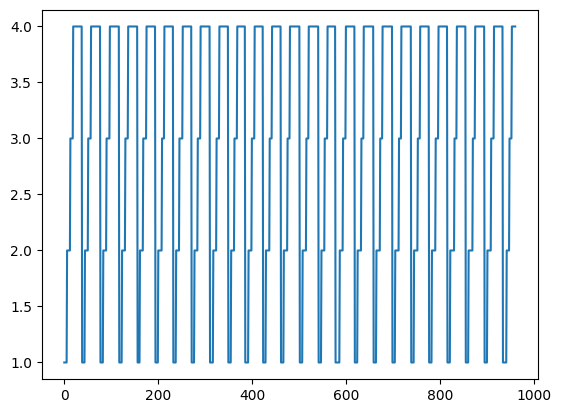

In [37]:
plt.plot(s_pred)

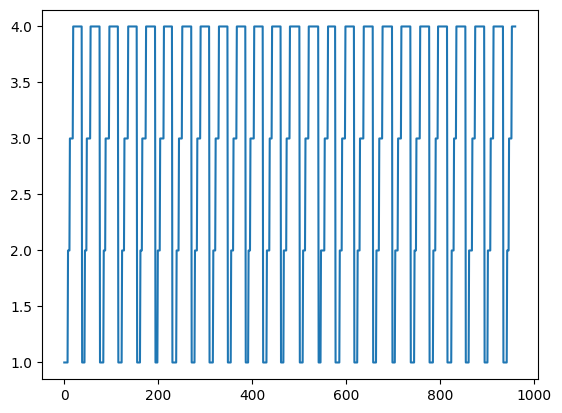

In [38]:
plt.plot(s_true)

In [67]:
matrix = confusion_matrix(s_true, s_pred_sqtm)
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

print(matrix)
print(per_class_accuracy)

[[151  19   0  11]
 [  2 126   0   0]
 [  0  43 130   1]
 [  3   0  12 462]]
[0.83425414 0.984375   0.74712644 0.96855346]


In [462]:
plt.subplot(2,1,1)
plt.plot(s_pred)
plt.subplot(2,1,2)
plt.plot(s_global)

In [425]:
s_pred_global = np.zeros(0)
s_true_global = np.zeros(0)

# Initialize the true positives, false positives and true total counters
tp = 0
fp = 0
ttot = 0

s_pred_global = np.append(s_pred_global, s_pred)
s_true_global = np.append(s_true_global, s[:s_pred.size])

In [426]:
def compute_tp_fp_ttot(s_true_orig: np.ndarray, s_pred_orig: np.ndarray) -> Tuple[int, int, int]:
    """Compute the true positives, false positives and the total number of S1
    and S2 true sounds, using the method described in [1].

    Args:
    -----
        s_true (np.ndarray): True states.
        s_pred (np.ndarray): Predicted states.

    Returns:
    --------
        tp (int): True positives.
        fp (int): False positives.
        ttot (int): Total number of S1 and S2 true sounds.
    
    References:
    -----------
        [1] S. E. Schmidt et al., "Segmentation of heart sound recordings by a
        duration-dependent hidden Markov model," Physiol. Meas., vol. 31, no. 4,
        pp. 513-29, Apr. 2010
    """
    # Copy the original arrays
    s_true = s_true_orig.copy()
    s_pred = s_pred_orig.copy()

    # The inputs are supposed to be 1D arrays of integers between 1 and 4 with
    # the same length, so make sure to decategoricalize them.
    
    # Check if s_true is a numpy array of 1D
    if not isinstance(s_true, np.ndarray) or s_true.ndim != 1:
        raise TypeError('s_true must be a numpy array of 1D.')
    
    # Check if s_pred is a numpy array of 1D
    if not isinstance(s_pred, np.ndarray) or s_pred.ndim != 1:
        raise TypeError('s_pred must be a numpy array of 1D.')
    
    # Check if s_true and s_pred have the same length
    if s_true.shape[0] != s_pred.shape[0]:
        raise ValueError('s_true and s_pred must have the same length.')
 
    # Make systolic and diastolic states 0 (i.e. the 2 and 4 states are zero now)
    s_true[s_true == 2] = 0
    s_true[s_true == 4] = 0

    s_pred[s_pred == 2] = 0
    s_pred[s_pred == 4] = 0

    # Obtain the difference of each array
    true_diff = np.diff(s_true)
    pred_diff = np.diff(s_pred)

    # If the first non-zero element of [true|pred]_diff is negative, substitude it by 0
    # to remove a non-complete S1 or S2 sound
    # Obtain the first non-zero element of [true|pred]_diff
    first_non_zero = np.nonzero(true_diff)[0][0]
    if true_diff[first_non_zero] < 0:
        true_diff[first_non_zero] = 0
    
    if np.count_nonzero(pred_diff):
        first_non_zero = np.nonzero(pred_diff)[0][0]
        if pred_diff[first_non_zero] < 0:
            pred_diff[first_non_zero] = 0

    # Calculate the number of complete S1 states in each array. The start of
    # these states are marked with 1's in the arrays abd the end are marked with
    # -1's. The number of complete S1 states is the minimum.
    true_S1 = min(np.count_nonzero(true_diff == 1), np.count_nonzero(true_diff == -1))
    pred_S1 = min(np.count_nonzero(pred_diff == 1), np.count_nonzero(pred_diff == -1))

    # Find the centers of each S1 state in the true and predicted arrays
    true_S1_centers = np.zeros(true_S1)
    for i in range(true_S1):
        lower_bound = np.where(true_diff == 1)[0][i]
        upper_bound = np.where(true_diff[lower_bound:] == -1)[0][0] + lower_bound + 1
        
        true_S1_centers[i] = (lower_bound + upper_bound) / 2

    pred_S1_centers = np.zeros(pred_S1)
    for i in range(pred_S1):
        lower_bound = np.where(pred_diff == 1)[0][i]
        upper_bound = np.where(pred_diff[lower_bound:] == -1)[0][0] + lower_bound + 1
        
        pred_S1_centers[i] = (lower_bound + upper_bound) / 2
    
    # Calculate the difference between the centers of the S1 states in the true
    # and predicted arrays using the nearest element and mark them as true
    # positive if the difference is less than 60 ms
    true_positives = np.zeros(pred_S1, dtype=bool)
    if true_S1:
        for i in range(pred_S1):
            # Find the nearest true_S1_center
            nearest_true_S1_center = true_S1_centers[np.argmin(np.abs(true_S1_centers - pred_S1_centers[i]))]

            # Mark the true positive if the difference is less than 60 ms (3 samples)
            if np.abs(pred_S1_centers[i] - nearest_true_S1_center) < 3:
                true_positives[i] = True
    
    # Calculate the true positives and false positives
    tp = np.count_nonzero(true_positives)
    fp = np.count_nonzero(np.logical_not(true_positives))

    # Do the same process for the S2 states

    # Calculate the number of complete S2 states in each array. The start of
    # these states are marked with 3's in the arrays abd the end are marked with
    # -3's. The number of complete S2 states is the minimum.
    true_S2 = min(np.count_nonzero(true_diff == 3), np.count_nonzero(true_diff == -3))
    pred_S2 = min(np.count_nonzero(pred_diff == 3), np.count_nonzero(pred_diff == -3))

    # Find the centers of each S2 state in the true and predicted arrays
    true_S2_centers = np.zeros(true_S2)
    for i in range(true_S2):
        lower_bound = np.where(true_diff == 3)[0][i]
        upper_bound = np.where(true_diff[lower_bound:] == -3)[0][0] + lower_bound + 1
        
        true_S2_centers[i] = (lower_bound + upper_bound) / 2

    pred_S2_centers = np.zeros(pred_S2)
    for i in range(pred_S2):
        lower_bound = np.where(pred_diff == 3)[0][i]
        upper_bound = np.where(pred_diff[lower_bound:] == -3)[0][0] + lower_bound + 1
        
        pred_S2_centers[i] = (lower_bound + upper_bound) / 2
    
    # Calculate the difference between the centers of the S2 states in the true
    # and predicted arrays using the nearest element and mark them as true
    # positive if the difference is less than 60 ms
    true_positives = np.zeros(pred_S2, dtype=bool)
    if true_S2:
        for i in range(pred_S2):
            # Find the nearest true_S2_center
            nearest_true_S2_center = true_S2_centers[np.argmin(np.abs(true_S2_centers - pred_S2_centers[i]))]

            # Mark the true positive if the difference is less than 60 ms (3 samples)
            if np.abs(pred_S2_centers[i] - nearest_true_S2_center) < 3:
                true_positives[i] = True
    
    # Calculate the true positives and false positives
    tp += np.count_nonzero(true_positives)
    fp += np.count_nonzero(np.logical_not(true_positives))

    return tp, fp, true_S1 + true_S2

## OLD PREP

In [70]:
N=64
tau=8

X = np.zeros((0, 4, N))
S = np.zeros((0, N))

# Get envelopes
x_global = pre_proc_data_40840_orig
s_global = s


# Extract the indexes of the s elements with heart state information
labeled_idxs_global = np.where(s_global!=0)[0]

# Find 0 intervals between heart state changes
zero_intervals = np.diff(labeled_idxs_global)-1 != 0

# Split x and s between those intervals
x_split = np.split(x_global, labeled_idxs_global[1:][zero_intervals], axis=1)
s_split = np.split(s_global, labeled_idxs_global[1:][zero_intervals])

for k in range(len(x_split)):

    # Extract the indexes of the s elements with heart state information
    labeled_idxs = np.where(s_split[k]!=0)[0]

    # Use only data with heart state information
    x = x_split[k][:, labeled_idxs]
    s = s_split[k][labeled_idxs]
    
    if x.shape[1] < N:
        # If the window is smaller than N, discard it
        continue

    x = rolling_strided_window(x, N, tau)
    s = rolling_strided_window(s, N, tau)

    x, s = check_valid_sequence(x, s, 1)

    # Stack the windows
    X = np.vstack((X, x))
    S = np.vstack((S, s))
        
    # Create a new axis in S and concatenate X and S
    S = S[:, np.newaxis, :]
    XS = np.concatenate((X, S), axis=1)

    # Shuffle the samples
    #np.random.shuffle(XS)

    # Return the X and S arrays
    X = XS[:, :x.shape[1], :]
    S = XS[:, x.shape[1]:, :]

    # Swap axes to format the data as channels_last
    X = np.swapaxes(X, 1, 2)
    S = np.swapaxes(S, 1, 2)

    # Transform S to categorical
    S = to_categorical(S-1)

In [71]:
output = model.predict(X)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [72]:
s_pred = unroll_strided_windows(output, tau)
s_true = unroll_strided_windows(S, tau)

In [73]:
s_pred = np.squeeze(s_pred.argmax(axis=-1)+1)
s_true = np.squeeze(s_true.argmax(axis=-1)+1)

In [75]:
s_pred_sqtm_old = seq_max_temporal_model(s_pred)

In [76]:
acc_value = accuracy_score(s_true, s_pred_sqtm_old, normalize=True)
print(acc_value)

0.9125


In [77]:
matrix = confusion_matrix(s_true, s_pred_sqtm_old)
per_class_accuracy = matrix.diagonal()/matrix.sum(axis=1)

print(matrix)
print(per_class_accuracy)

[[154  19   0   8]
 [  2 126   0   0]
 [  0  38 135   1]
 [  4   0  12 461]]
[0.85082873 0.984375   0.77586207 0.96645702]
